## Topics
1. Review of model evaluation procedures
2. Steps for K-fold cross-validation
3. Comparing cross-validation to train/test split
4. Cross-validation recommendations
5. Cross-validation example: parameter tuning
6. Cross-validation example: model selection
7. Cross-validation example: feature selection
8. Improvements to cross-validation
9. Resources

### 1. Review of model evaluation procedures

**Motivation:** Need a way to choose between machine learning models

- Goal is to estimate likely performance of a model on **out-of-sample data**

**Initial idea:** Train and test on the same data

- But, maximizing **training accuracy** rewards overly complex models which **overfit** the training data

**Alternative idea:** Train/test split

- Split the dataset into two pieces, so that the model can be trained and tested on **different data**
- **Testing accuracy** is a better estimate than training accuracy of out-of-sample performance
- Problem with train/test split
    - It provides a **high variance** estimate since changing which observations happen to be in the testing set can significantly change testing accuracy
    - Testing accuracy can change a lot depending on a which observation happen to be in the testing set

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# read in the iris data
iris = load_iris()

# create X (features) and y (response)
X = iris.data
y = iris.target

In [4]:
X.shape

(150, 4)

In [5]:
y.shape

(150,)

In [6]:
# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the accuracy changes a lot
# this is why testing accuracy is a high-variance estimate
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6)

# check classification accuracy of KNN with K=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9736842105263158

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9473684210526315

In [8]:
(y_pred == y_test).mean()

0.9473684210526315

**Question:** What if we created a bunch of train/test splits, calculated the testing accuracy for each, and averaged the results together?

**Answer:** That's the essense of cross-validation!

### 2. Steps for K-fold cross-validation

1. Split the dataset into K **equal** partitions (or "folds")
    - So if k = 5 and dataset has 150 observations
    - Each of the 5 folds would have 30 observations
2. Use fold 1 as the **testing set** and the union of the other folds as the **training set**
    - Testing set = 30 observations (fold 1)
    - Training set = 120 observations (folds 2-5)
3. Calculate **testing accuracy**
4. Repeat steps 2 and 3 K times, using a **different fold** as the testing set each time
    - We will repeat the process 5 times
    - 2nd iteration
        - fold 2 would be the testing set
        - union of fold 1, 3, 4, and 5 would be the training set
    - 3rd iteration
        - fold 3 would be the testing set
        - union of fold 1, 2, 4, and 5 would be the training set
    - And so on...
5. Use the **average testing accuracy** as the estimate of out-of-sample accuracy

Diagram of **5-fold cross-validation:**

![5-fold cross-validation](images/07_cross_validation_diagram.png)

In [9]:
# simulate splitting a dataset of 25 observations into 5 folds
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False)


# print the contents of each training and testing set
# ^ - forces the field to be centered within the available space
# .format() - formats the string similar to %s or %n
# enumerate(sequence, start=0) - returns an enumerate object
print('{} {:^61} {}'.format('Iteration', 
    'Training set obsevations', 'Testing set observations'))

for iteration, data in enumerate(kf.split(X[:25], y[:25]), start=1):
    print('{!s:^9} {} {!s:^25}'.format(iteration, data[0], data[1]))

Iteration                   Training set obsevations                    Testing set observations
    1     [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [0 1 2 3 4]       
    2     [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [5 6 7 8 9]       
    3     [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22 23 24]     [10 11 12 13 14]     
    4     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 22 23 24]     [15 16 17 18 19]     
    5     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]     [20 21 22 23 24]     


- Dataset contains **25 observations** (numbered 0 through 24)
- 5-fold cross-validation, thus it runs for **5 iterations**
- For each iteration, every observation is either in the training set or the testing set, **but not both**
- Every observation is in the testing set **exactly once**

### 3. Comparing cross-validation to train/test split

Advantages of **cross-validation:**

- More accurate estimate of out-of-sample accuracy
- More "efficient" use of data
    - This is because every observation is used for both training and testing

Advantages of **train/test split:**

- Runs K times faster than K-fold cross-validation
    - This is because K-fold cross-validation repeats the train/test split K-times
- Simpler to examine the detailed results of the testing process

### 4. Cross-validation recommendations

1. K can be any number, but **K=10** is generally recommended
    - This has been shown experimentally to produce the best out-of-sample estimate
2. For classification problems, **stratified sampling** is recommended for creating the folds
    - Each response class should be represented with equal proportions in each of the K folds
        - If dataset has 2 response classes 
            - Spam/Ham
            - 20% observation = ham
            - Each cross-validation fold should consist of exactly 20% ham
    - scikit-learn's `cross_val_score` function does this by default

### 5. Cross-validation example: parameter tuning

**Goal:** Select the best tuning parameters (aka "hyperparameters") for KNN on the iris dataset
- We want to choose the best tuning parameters that best generalize the data

In [10]:
from sklearn.model_selection import cross_val_score

In [11]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
# k = 5 for KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

# Use cross_val_score function
# We are passing the entirety of X and y, not X_train or y_train, 
# it takes care of splitting the data
# cv=10 for 10 folds
# scoring='accuracy' for evaluation metric - althought they are many
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

[1.         0.93333333 1.         1.         0.86666667 0.93333333
 0.93333333 1.         1.         1.        ]


- In the first iteration, the accuracy is 100%
- Second iteration, the accuracy is 93% and so on

**cross_val_score executes the first 4 steps of k-fold cross-validation steps which I have broken down to 7 steps here in detail**
1. Split the dataset (X and y) into K=10 **equal** partitions (or "folds")
2. Train the KNN model on union of folds 2 to 10 (training set)
3. Test the model on fold 1 (testing set) and calculate testing accuracy
4. Train the KNN model on union of fold 1 and fold 3 to 10 (training set)
5. Test the model on fold 2 (testing set) and calculate testing accuracy
6. It will do this on 8 more times
7. When finished, it will return the 10 testing accuracy scores as a numpy array

In [12]:
# use average accuracy as an estimate of out-of-sample accuracy
# numpy array has a method mean()
print(scores.mean())

0.9666666666666668


Our goal here is to find the optimal value of K

In [13]:
from tqdm.notebook import tqdm

In [14]:
# search for an optimal value of K for KNN

# range of k we want to try
k_range = range(1, 31)
# empty list to store scores
k_scores = []

# 1. we will loop through reasonable values of k
for k in tqdm(k_range):
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())
    

print(k_scores)

  0%|          | 0/30 [00:00<?, ?it/s]

[0.96, 0.9533333333333334, 0.9666666666666666, 0.9666666666666666, 0.9666666666666668, 0.9666666666666668, 0.9666666666666668, 0.9666666666666668, 0.9733333333333334, 0.9666666666666668, 0.9666666666666668, 0.9733333333333334, 0.9800000000000001, 0.9733333333333334, 0.9733333333333334, 0.9733333333333334, 0.9733333333333334, 0.9800000000000001, 0.9733333333333334, 0.9800000000000001, 0.9666666666666666, 0.9666666666666666, 0.9733333333333334, 0.96, 0.9666666666666666, 0.96, 0.9666666666666666, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334]


In [15]:
# in essence, this is basically running the k-fold cross-validation method 30 times because we want to run through K values from 1 to 30
# we should have 30 scores here
print('Length of list', len(k_scores))
print('Max of list', max(k_scores))

Length of list 30
Max of list 0.9800000000000001


Text(0, 0.5, 'Cross-validated accuracy')

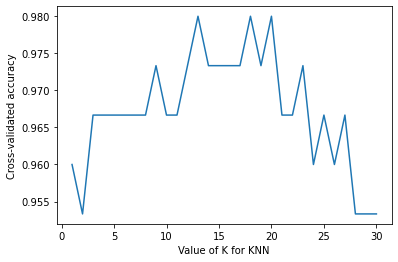

In [16]:
# plot how accuracy changes as we vary k
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
# plt.plot(x_axis, y_axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

The maximum cv accuracy occurs from k=13 to k=20
- The general shape of the curve is an upside down yield
    - This is quite typical when examining the model complexity and accuracy
    - This is an example of bias-variance trade off
        - Low values of k (low bias, high variance)
            - The 1-Nearest Neighbor classifier is the most complex nearest neighbor model
            - It has the most jagged decision boundary, and is most likely to overfit
        - High values of k (high bias, low variance) 
            - underfit
        - Best value is the middle of k (most likely to generalize out-of-sample data)
            - just right
    
- The best value of k
    - Higher values of k produce less complex model
        - So we will choose 20 as our best KNN model

### 6. Cross-validation example: model selection

**Goal:** Compare the best KNN model with logistic regression on the iris dataset

In [17]:
# 10-fold cross-validation with the best KNN model
knn = KNeighborsClassifier(n_neighbors=20)

# Instead of saving 10 scores in object named score and calculating mean
# We're just calculating the mean directly on the results
print(cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean())

0.9800000000000001


In [18]:
# 10-fold cross-validation with logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
print(cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())

0.9733333333333334


We can conclude that KNN is likely a better choice than logistic regression

### 7. Cross-validation example: feature selection

**Goal**: Select whether the Newspaper feature should be included in the linear regression model on the advertising dataset

In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [20]:
# read in the advertising dataset
data = pd.read_csv('Advertising.csv', index_col=0)
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [21]:
# create a Python list of three feature names
feature_cols = ['TV', 'Radio', 'Newspaper']

# use the list to select a subset of the DataFrame (X)
X = data[feature_cols]

# select the Sales column as the response (y)
# since we're selecting only one column, we can select the attribute using .attribute
y = data.Sales

In [22]:
# 10-fold cross-validation with all three features
# instantiate model
lm = LinearRegression()

# store scores in scores object
# we can't use accuracy as our evaluation metric since that's only relevant for classification problems
# RMSE is not directly available so we will use MSE
scores = cross_val_score(lm, X, y, cv=10, scoring='neg_mean_squared_error')
print(scores)

[-3.56038438 -3.29767522 -2.08943356 -2.82474283 -1.3027754  -1.74163618
 -8.17338214 -2.11409746 -3.04273109 -2.45281793]


In [23]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

MSE should be positive
- But why is the MSE here negative?
- MSE is a loss function
    - It is something we want to minimize
    - A design decision was made so that the results are made negative
    - The best results would be the largest number (the least negative) so we can still maximize similar to classification accuracy
- Classification Accuracy is a reward function
    - It is something we want to maximize

In [24]:
# fix the sign of MSE scores
mse_scores = -scores
print(mse_scores)

[3.56038438 3.29767522 2.08943356 2.82474283 1.3027754  1.74163618
 8.17338214 2.11409746 3.04273109 2.45281793]


In [25]:
# convert from MSE to RMSE
rmse_scores = np.sqrt(mse_scores)
print(rmse_scores)

[1.88689808 1.81595022 1.44548731 1.68069713 1.14139187 1.31971064
 2.85891276 1.45399362 1.7443426  1.56614748]


In [26]:
# calculate the average RMSE
print(rmse_scores.mean())

1.6913531708051792


In [27]:
# 10-fold cross-validation with two features (excluding Newspaper)
feature_cols = ['TV', 'Radio']
X = data[feature_cols]
print(np.sqrt(-cross_val_score(lm, X, y, cv=10, scoring='neg_mean_squared_error')).mean())

1.6796748419090766


Without Newspaper
- Average RMSE = 1.68
- lower number than with model with Newspaper
    - RMSE is something we want to minimize
    - So the model excluding Newspaper is a better model

### 8. Improvements to cross-validation

**Repeated cross-validation**

- Repeat cross-validation multiple times (with **different random splits** of the data) and average the results
- More reliable estimate of out-of-sample performance by **reducing the variance** associated with a single trial of cross-validation

**Creating a hold-out set**

- "Hold out" a portion of the data **before** beginning the model building process
- Locate the best model using cross-validation on the remaining data, and test it **using the hold-out set**
- More reliable estimate of out-of-sample performance since hold-out set is **truly out-of-sample**

**Feature engineering and selection within cross-validation iterations**

- Normally, feature engineering and selection occurs **before** cross-validation
- Instead, perform all feature engineering and selection **within each cross-validation iteration**
- More reliable estimate of out-of-sample performance since it **better mimics** the application of the model to out-of-sample data

### 9. Resources

- scikit-learn documentation: [Cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html), [Model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html)
- scikit-learn issue on GitHub: [MSE is negative when returned by cross_val_score](https://github.com/scikit-learn/scikit-learn/issues/2439)
- Section 5.1 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) (11 pages) and related videos: [K-fold and leave-one-out cross-validation](https://www.youtube.com/watch?v=nZAM5OXrktY) (14 minutes), [Cross-validation the right and wrong ways](https://www.youtube.com/watch?v=S06JpVoNaA0) (10 minutes)
- Scott Fortmann-Roe: [Accurately Measuring Model Prediction Error](http://scott.fortmann-roe.com/docs/MeasuringError.html)
- Machine Learning Mastery: [An Introduction to Feature Selection](http://machinelearningmastery.com/an-introduction-to-feature-selection/)
- Harvard CS109: [Cross-Validation: The Right and Wrong Way](https://github.com/cs109/content/blob/master/lec_10_cross_val.ipynb)
- Journal of Cheminformatics: [Cross-validation pitfalls when selecting and assessing regression and classification models](http://www.jcheminf.com/content/pdf/1758-2946-6-10.pdf)

_This tutorial is derived from Data School's Machine Learning with scikit-learn tutorial. Ritchie Ng added notes so anyone, including myself, can refer to this tutorial without watching the videos._